In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

import Bargaining as brg

do_cpp = True
do_compile = True

In [2]:
# solve model
T = 10
model_cpp = brg.HouseholdModelClass(par={'T':T,'phi_w':0.2,'phi_m':0.2,'sigma_love':0.1,'div_A_share':0.3,'do_cpp':True})
model_cpp.link_to_cpp(force_compile=do_compile,do_print=False)
%time model_cpp.solve()

model = brg.HouseholdModelClass(par={'T':T,'phi_w':0.2,'phi_m':0.2,'sigma_love':0.1,'div_A_share':0.3,'do_cpp':False})
%time model.solve()

# 8.95s vs
# 7min 47s vs 14min 51s

Wall time: 9.24 s
Wall time: 9min 37s


0.028054060250990664


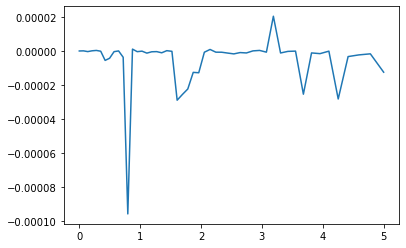

In [3]:
t = 0
val = 'C_pub_couple'

iP = 10 #10
iL = 5

diff = getattr(model.sol,val) - getattr(model_cpp.sol,val)
plt.plot(model.par.grid_A,diff[t,iP,iL]);
print(np.max(np.abs(diff.ravel())))

In [4]:
for val in ('Vw_couple','Vm_couple','Cw_priv_couple','Cm_priv_couple','C_pub_couple','power'):
    diff = getattr(model.sol,val) - getattr(model_cpp.sol,val)
    gns = np.mean(getattr(model_cpp.sol,val).ravel())
    print(f'{val}: {np.max(np.abs(diff.ravel())):2.5f} (gns: {gns:2.5})')

Vw_couple: 0.05954 (gns: -1.4865)
Vm_couple: 0.00024 (gns: -1.4516)
Cw_priv_couple: 0.01590 (gns: 0.61366)
Cm_priv_couple: 0.03035 (gns: 0.67238)
C_pub_couple: 0.02805 (gns: 1.0351)
power: 0.00522 (gns: -0.16908)


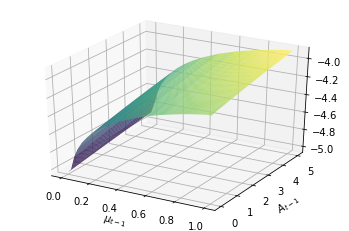

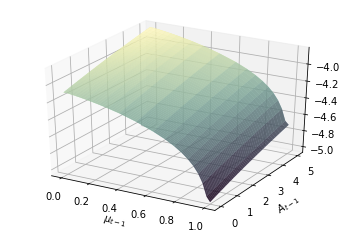

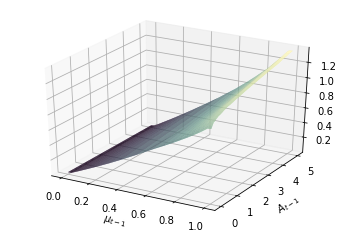

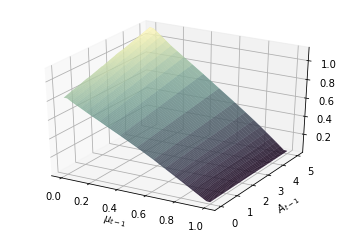

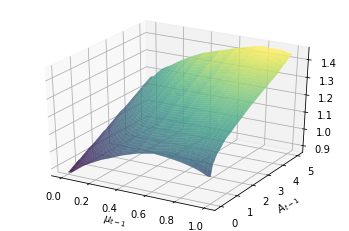

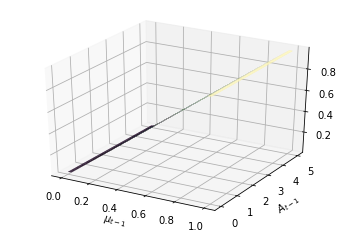

In [5]:
cmaps = ('viridis','gray')
model_list = (model,model_cpp)
t = 0 #par.T-1 -1

par = model.par
X, Y = np.meshgrid(par.grid_power, par.grid_A,indexing='ij')

for iL in (par.num_love//2,): 
    for var in ('Vw_couple','Vm_couple','Cw_priv_couple','Cm_priv_couple','C_pub_couple','power'):

        fig = plt.figure()
        ax = plt.axes(projection='3d')
        
        for i,model_now in enumerate(model_list):
       
            Z = getattr(model_now.sol,var)[t,:,iL,:]
            ax.plot_surface(X, Y, Z,rstride=1,cstride=1,cmap=cmaps[i], edgecolor='none',alpha=0.6);           
            ax.set(xlabel='$\mu_{t-1}$',ylabel='$A_{t-1}$');
